In [ ]:
!unzip '/content/Dataset.zip'

Archive:  /content/Dataset.zip
   creating: Dataset/
   creating: Dataset/ankylosaurus/
  inflating: Dataset/ankylosaurus/1.png  
  inflating: Dataset/ankylosaurus/10.png  
  inflating: Dataset/ankylosaurus/11.png  
  inflating: Dataset/ankylosaurus/12.png  
  inflating: Dataset/ankylosaurus/13.png  
  inflating: Dataset/ankylosaurus/14.png  
  inflating: Dataset/ankylosaurus/15.png  
  inflating: Dataset/ankylosaurus/16.png  
  inflating: Dataset/ankylosaurus/17.png  
  inflating: Dataset/ankylosaurus/18.png  
  inflating: Dataset/ankylosaurus/19.png  
  inflating: Dataset/ankylosaurus/2.png  
  inflating: Dataset/ankylosaurus/20.png  
  inflating: Dataset/ankylosaurus/21.png  
  inflating: Dataset/ankylosaurus/22.png  
  inflating: Dataset/ankylosaurus/23.png  
  inflating: Dataset/ankylosaurus/24.png  
  inflating: Dataset/ankylosaurus/25.png  
  inflating: Dataset/ankylosaurus/26.png  
  inflating: Dataset/ankylosaurus/27.png  
  inflating: Dataset/ankylosaurus/28.png  
  inflating

In [ ]:
import cv2 as cv
import torch
import numpy as np
from os import listdir
from torch.utils.data import Dataset


class getImageLabel(Dataset):
    def __init__(self, folder='./Dataset'):
        self.dataset = []

        # initiate the one hot encoding for class
        to_one_hot = np.eye(5)  # number of class
        for i, dino in enumerate(sorted(listdir(folder))):
            for image_name in listdir(folder + "/" + dino):
                # read image, resize image, and normalize image to 0-1 range
                image = cv.resize(cv.imread(folder + "/" + dino + "/" + image_name), (100, 100)) / 255
                # append feature image and one hot encoded label to public self.dataset
                self.dataset.append([image, to_one_hot[i]])

    def __getitem__(self, item):
        feature, label = self.dataset[item]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, input_dim=200, input_c=3, output=5, hidden_dim=128, dropout=0.5, device='cpu'):
        super(SimpleCNN, self).__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_c, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )
        self.fc = nn.Linear(in_features=50 * 9 * 9, out_features=output)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)

        x = self.fc(torch.flatten(x, 1))
        x = self.Softmax(x)

        return x

epoch =  1 train loss =  1.613469089780535 , test loss =  1.591976182801383
epoch =  2 train loss =  1.5791281461715698 , test loss =  1.5372576713562012
epoch =  3 train loss =  1.4830692495618547 , test loss =  1.347087093761989
epoch =  4 train loss =  1.2899998937334334 , test loss =  1.3005920137677873
epoch =  5 train loss =  1.2096109560557775 , test loss =  1.1390961068017142
epoch =  6 train loss =  1.1837446178708757 , test loss =  1.2501580289431982
epoch =  7 train loss =  1.1455321652548653 , test loss =  1.1033352272851127
epoch =  8 train loss =  1.0811151947293962 , test loss =  1.1061807019369942
epoch =  9 train loss =  1.0770983695983887 , test loss =  1.1002528412001473
epoch =  10 train loss =  1.0770316464560372 , test loss =  1.0800768392426627
epoch =  11 train loss =  1.0449522733688354 , test loss =  1.0250636168888636
epoch =  12 train loss =  1.0175702231270927 , test loss =  1.0027980038097926
epoch =  13 train loss =  1.0033357739448547 , test loss =  1.01

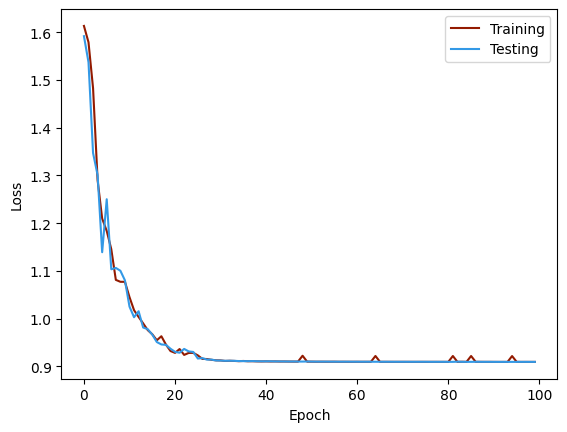

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam




def main():
    BATCH_SIZE = 32
    EPOCH = 100
    LEARNING_RATE = 0.001

    train_loader = DataLoader(getImageLabel(folder="./Dataset"), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(getImageLabel(folder="./Dataset"), batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128, dropout=0.5, device='cpu')
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss()

    loss_train_all, loss_test_all = [], []
    for epoch in range(EPOCH):
        train_loss = 0
        test_loss = 0
        model.train()
        for batch, (src, trg) in enumerate(train_loader):
            src = torch.permute(src, (0, 3, 1, 2))
            pred = model(src)
            loss = loss_function(pred, trg)
            train_loss += loss.detach().numpy()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    #
        model.eval()
        for batch, (src, trg) in enumerate(test_loader):
            src = torch.permute(src, (0, 3, 1, 2))

            pred = model(src)
            loss = loss_function(pred, trg)
            test_loss += loss.detach().numpy()

        loss_train_all.append(train_loss / len(train_loader))
        loss_test_all.append(test_loss / len(test_loader))
        print("epoch = ", epoch+1,"train loss = ", train_loss / len(train_loader), ", test loss = ", test_loss / len(test_loader))

        if (epoch+1) % 50 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss / len(train_loader),
            }, "./SimpleCNN_" + str(epoch+1) + ".pt")

    plt.plot(range(EPOCH), loss_train_all, color="#931a00", label='Training')
    plt.plot(range(EPOCH), loss_test_all, color="#3399e6", label='Testing')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("./training.png")



if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def main():
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    test_loader = DataLoader(getImageLabel(folder="./Dataset"), batch_size=BATCH_SIZE, shuffle=True)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128, dropout=0.5, device='cpu')
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    checkpoint = torch.load('SimpleCNN_100.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_batch = checkpoint['loss']

    prediction, ground_truth = [], []
    with torch.no_grad():
        model.eval()
        for batch, (src, trg) in enumerate(test_loader):
            src = torch.permute(src, (0, 3, 1, 2))

            pred = model(src)
            prediction.extend(torch.argmax(pred,dim=1).detach().numpy())
            ground_truth.extend(torch.argmax(trg, dim=1).detach().numpy())

    classes = ('ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops')

    # # Build confusion matrix
    # cf_matrix = confusion_matrix(ground_truth, prediction)
    # print(cf_matrix)
    # df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
    #                      columns=[i for i in classes])
    # plt.figure(figsize=(12, 7))
    # sn.heatmap(df_cm, annot=True)
    # plt.savefig('confusion_matrix.png')


    print("accuracy score = ", accuracy_score(ground_truth, prediction))
    print("precision score = ", precision_score(ground_truth, prediction, average='weighted'))
    print("recall score = ", recall_score(ground_truth, prediction, average='weighted'))
    print("f1 score score = ", f1_score(ground_truth, prediction, average='weighted'))


if __name__ == "__main__":
    main()


<ipython-input-7-df99d91ae22f>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('SimpleCNN_100.pt')


accuracy score =  0.995
precision score =  0.9951219512195122
recall score =  0.995
f1 score score =  0.9949992186279107
